# Plasticity of Mohr-Coulomb with apex-smoothing

This tutorial aims to demonstrate how modern automatic algorithmic
differentiation (AD) techniques may be used to define a complex constitutive
model demanding a lot of by-hand differentiation. In particular, we implement
the non-associative plasticity model of Mohr-Coulomb with apex-smoothing applied
to a slope stability problem for soil. We use the
[JAX](https://jax.readthedocs.io/en/latest/) package to define constitutive
relations including the differentiation of certain terms and
`FEMExternalOperator` class to incorporate this model into a weak formulation
within [UFL](https://github.com/fenics/ufl).

The tutorial is based on the
[limit analysis](https://fenics-optim.readthedocs.io/en/latest/demos/limit_analysis_3D_SDP.html)
within semi-definite programming framework, where the plasticity model was
replaced by the MFront/TFEL
[implementation](https://thelfer.github.io/tfel/web/MohrCoulomb.html) of
the Mohr-Coulomb elastoplastic model with apex smoothing.


## Problem formulation

We solve a slope stability problem of a soil domain $\Omega$ represented by a
rectangle $[0; L] \times [0; W]$ with homogeneous Dirichlet boundary conditions
for the displacement field $\boldsymbol{u} = \boldsymbol{0}$ on the right side
$x = L$ and the bottom one $z = 0$. The loading consists of a gravitational body
force $\boldsymbol{q}=[0, -\gamma]^T$ with $\gamma$ being the soil self-weight.
The solution of the problem is to find the collapse load $q_\text{lim}$, for
which we know an analytical solution in the case of the standard Mohr-Coulomb
model without smoothing under plane strain assumption for associative plastic law
{cite}`chenLimitAnalysisSoil1990`. Here we follow the same Mandel-Voigt notation
as in the [von Mises plasticity tutorial](demo_plasticity_von_mises.py).

If $V$ is a functional space of admissible displacement fields, then we can
write out a weak formulation of the problem:

Find $\boldsymbol{u} \in V$ such that

$$
    F(\boldsymbol{u}; \boldsymbol{v}) = \int\limits_\Omega
    \boldsymbol{\sigma}(\boldsymbol{u}) \cdot
    \boldsymbol{\varepsilon}(\boldsymbol{v}) \, \mathrm{d}\boldsymbol{x} -
    \int\limits_\Omega \boldsymbol{q} \cdot \boldsymbol{v} \, \mathrm{d}\boldsymbol{x} = \boldsymbol{0}, \quad
    \forall \boldsymbol{v} \in V,
$$
where $\boldsymbol{\sigma}$ is an external operator representing the stress tensor.

```{note}
Although the tutorial shows the implementation of the Mohr-Coulomb model, it
is quite general to be adapted to a wide rage of plasticity models that may
be defined through a yield surface and a plastic potential.
```

## Implementation

### Preamble

In [1]:
from mpi4py import MPI
from petsc4py import PETSc

import jax
import jax.lax
import jax.numpy as jnp
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from mpltools import annotation  # for slope markers
from solvers import LinearProblem, SNESProblem
from utilities import find_cell_by_point

import basix
import ufl
from dolfinx import default_scalar_type, fem, mesh, common
from dolfinx_external_operator import (
    FEMExternalOperator,
    evaluate_external_operators,
    evaluate_operands,
    replace_external_operators,
)

jax.config.update("jax_enable_x64", True)

Here we define geometrical and material parameters of the problem as well as
some useful constants.

In [2]:
E =  1.0  # [MPa] Young modulus
nu = 0.25  # [-] Poisson ratio
c = 3.45 / 6778 # [MPa] cohesion
phi = 30 * np.pi / 180  # [rad] friction angle
psi = 30 * np.pi / 180  # [rad] dilatancy angle
theta_T = 26 * np.pi / 180  # [rad] transition angle as defined by Abbo and Sloan
a = 0.26 * c / np.tan(phi)  # [MPa] tension cuff-off parameter

In [3]:
L, H = (1.2, 1.0)
Nx, Ny = (200, 200)
gamma = 1.0 / 6778
domain = mesh.create_rectangle(MPI.COMM_WORLD, [np.array([0, 0]), np.array([L, H])], [Nx, Ny])

In [4]:
domain.topology.index_map(0).size_global

40401

In [5]:
k_u = 2
gdim = domain.topology.dim
V = fem.functionspace(domain, ("Lagrange", k_u, (gdim,)))


# Boundary conditions
def on_right(x):
    return np.isclose(x[0], L)


def on_bottom(x):
    return np.isclose(x[1], 0.0)


bottom_dofs = fem.locate_dofs_geometrical(V, on_bottom)
right_dofs = fem.locate_dofs_geometrical(V, on_right)

bcs = [
    fem.dirichletbc(np.array([0.0, 0.0], dtype=PETSc.ScalarType), bottom_dofs, V),
    fem.dirichletbc(np.array([0.0, 0.0], dtype=PETSc.ScalarType), right_dofs, V),
]


def epsilon(v):
    grad_v = ufl.grad(v)
    return ufl.as_vector(
        [
            grad_v[0, 0],
            grad_v[1, 1],
            0.0,
            np.sqrt(2.0) * 0.5 * (grad_v[0, 1] + grad_v[1, 0]),
        ]
    )


k_stress = 2 * (k_u - 1)

dx = ufl.Measure(
    "dx",
    domain=domain,
    metadata={"quadrature_degree": k_stress, "quadrature_scheme": "default"},
)

stress_dim = 2 * gdim
S_element = basix.ufl.quadrature_element(domain.topology.cell_name(), degree=k_stress, value_shape=(stress_dim,))
S = fem.functionspace(domain, S_element)


Du = fem.Function(V, name="Du")
u = fem.Function(V, name="Total_displacement")
du = fem.Function(V, name="du")
v = ufl.TestFunction(V)

sigma = FEMExternalOperator(epsilon(Du), function_space=S)
sigma_n = fem.Function(S, name="sigma_n")

### Defining plasticity model and external operator

The constitutive model of the soil is described by a non-associative plasticity
law without hardening that is defined by the Mohr-Coulomb yield surface $f$ and
the plastic potential $g$. Both quantities may be expressed through the
following function $h$

\begin{align*}
    & h(\boldsymbol{\sigma}, \alpha) =
    \frac{I_1(\boldsymbol{\sigma})}{3}\sin\alpha +
    \sqrt{J_2(\boldsymbol{\sigma}) K^2(\alpha) + a^2(\alpha)\sin^2\alpha} -
    c\cos\alpha, \\
    & f(\boldsymbol{\sigma}) = h(\boldsymbol{\sigma}, \phi), \\
    & g(\boldsymbol{\sigma}) = h(\boldsymbol{\sigma}, \psi),
\end{align*}
where $\phi$ and $\psi$ are friction and dilatancy angles, $c$ is a cohesion,
$I_1(\boldsymbol{\sigma}) = \mathrm{tr} \boldsymbol{\sigma}$ is the first
invariant of the stress tensor and $J_2(\boldsymbol{\sigma}) =
\frac{1}{2}\boldsymbol{s} \cdot \boldsymbol{s}$ is the second invariant of the
deviatoric part of the stress tensor. The expression of the coefficient
$K(\alpha)$ may be found in the MFront/TFEL
[implementation](https://thelfer.github.io/tfel/web/MohrCoulomb.html) of this plastic model.

During the plastic loading the stress-strain state of the solid must satisfy
the following system of nonlinear equations

$$

    \begin{cases}
        \boldsymbol{r}_{g}(\boldsymbol{\sigma}_{n+1}, \Delta\lambda) =
        \boldsymbol{\sigma}_{n+1} - \boldsymbol{\sigma}_n -
        \boldsymbol{C} \cdot (\Delta\boldsymbol{\varepsilon} - \Delta\lambda
        \frac{\mathrm{d} g}{\mathrm{d}\boldsymbol{\sigma}}(\boldsymbol{\sigma_{n+1}})) =
        \boldsymbol{0}, \\
         r_f(\boldsymbol{\sigma}_{n+1}) = f(\boldsymbol{\sigma}_{n+1}) = 0,
    \end{cases}

$$ (eq_MC_1)
where $\Delta$ is associated with increments of a quantity between the next
loading step $n + 1$ and the current loading step $n$.

By introducing the residual vector $\boldsymbol{r} = [\boldsymbol{r}_{g}^T,
r_f]^T$ and its argument vector $\boldsymbol{y}_{n+1} =
[\boldsymbol{\sigma}_{n+1}^T, \Delta\lambda]^T$, we obtain the following
nonlinear constitutive equation:

$$
    \boldsymbol{r}(\boldsymbol{y}_{n+1}) = \boldsymbol{0}.
$$

To solve this equation we apply the Newton method and introduce the local
Jacobian of the residual vector $\boldsymbol{j} := \frac{\mathrm{d}
\boldsymbol{r}}{\mathrm{d} \boldsymbol{y}}$. Thus we solve the following linear
system at each quadrature point for the plastic phase

$$
    \begin{cases}
        \boldsymbol{j}(\boldsymbol{y}_{n})\boldsymbol{t} = -
        \boldsymbol{r}(\boldsymbol{y}_{n}), \\
        \boldsymbol{x}_{n+1} = \boldsymbol{x}_n + \boldsymbol{t}.
    \end{cases}
$$

During the elastic loading, we consider a trivial system of equations

$$
    \begin{cases}
        \boldsymbol{\sigma}_{n+1} = \boldsymbol{\sigma}_n +
        \boldsymbol{C} \cdot \Delta\boldsymbol{\varepsilon}, \\ \Delta\lambda = 0.
    \end{cases}
$$ (eq_MC_2)

The algorithm solving the systems {eq}`eq_MC_1`--{eq}`eq_MC_2` is called the
*return-mapping procedure* and the solution defines the return-mapping
correction of the stress tensor. By implementation of the external operator
$\boldsymbol{\sigma}$ we mean the implementation of this *algorithmic*
procedure.

The automatic differentiation tools of the JAX library are applied to calculate
the three distinct derivatives:
1. $\frac{\mathrm{d} g}{\mathrm{d}\boldsymbol{\sigma}}$ - derivative
   of the plastic potential $g$,
2. $j = \frac{\mathrm{d} \boldsymbol{r}}{\mathrm{d} \boldsymbol{y}}$ -
   derivative of the local residual $\boldsymbol{r}$,
3. $\boldsymbol{C}_\text{tang} =
   \frac{\mathrm{d}\boldsymbol{\sigma}}{\mathrm{d}\boldsymbol{\varepsilon}}$ -
   stress tensor
derivative or consistent tangent moduli.

#### Defining yield surface and plastic potential

First of all, we define supplementary functions that help us to express the
yield surface $f$ and the plastic potential $g$. In the following definitions,
we use built-in functions of the JAX package, in particular, the conditional
primitive `jax.lax.cond`. It is necessary for the correct work of the AD tool
and just-in-time compilation. For more details, please, visit the JAX
[documentation](https://jax.readthedocs.io/en/latest/).

In [6]:
def J3(s):
    return s[2] * (s[0] * s[1] - s[3] * s[3] / 2.0)


def J2(s):
    return 0.5 * jnp.vdot(s, s)


def theta(s):
    J2_ = J2(s)
    arg = -(3.0 * np.sqrt(3.0) * J3(s)) / (2.0 * jnp.sqrt(J2_ * J2_ * J2_))
    arg = jnp.clip(arg, -1.0, 1.0)
    theta = 1.0 / 3.0 * jnp.arcsin(arg)
    return theta


def sign(x):
    return jax.lax.cond(x < 0.0, lambda x: -1, lambda x: 1, x)


def coeff1(theta, angle):
    return np.cos(theta_T) - (1.0 / np.sqrt(3.0)) * np.sin(angle) * np.sin(theta_T)


def coeff2(theta, angle):
    return sign(theta) * np.sin(theta_T) + (1.0 / np.sqrt(3.0)) * np.sin(angle) * np.cos(theta_T)


coeff3 = 18.0 * np.cos(3.0 * theta_T) * np.cos(3.0 * theta_T) * np.cos(3.0 * theta_T)


def C(theta, angle):
    return (
        -np.cos(3.0 * theta_T) * coeff1(theta, angle) - 3.0 * sign(theta) * np.sin(3.0 * theta_T) * coeff2(theta, angle)
    ) / coeff3


def B(theta, angle):
    return (
        sign(theta) * np.sin(6.0 * theta_T) * coeff1(theta, angle) - 6.0 * np.cos(6.0 * theta_T) * coeff2(theta, angle)
    ) / coeff3


def A(theta, angle):
    return (
        -(1.0 / np.sqrt(3.0)) * np.sin(angle) * sign(theta) * np.sin(theta_T)
        - B(theta, angle) * sign(theta) * np.sin(3 * theta_T)
        - C(theta, angle) * np.sin(3.0 * theta_T) * np.sin(3.0 * theta_T)
        + np.cos(theta_T)
    )


def K(theta, angle):
    def K_false(theta):
        return jnp.cos(theta) - (1.0 / np.sqrt(3.0)) * np.sin(angle) * jnp.sin(theta)

    def K_true(theta):
        return (
            A(theta, angle)
            + B(theta, angle) * jnp.sin(3.0 * theta)
            + C(theta, angle) * jnp.sin(3.0 * theta) * jnp.sin(3.0 * theta)
        )

    return jax.lax.cond(jnp.abs(theta) > theta_T, K_true, K_false, theta)


def a_g(angle):
    return a * np.tan(phi) / np.tan(angle)


dev = np.array(
    [
        [2.0 / 3.0, -1.0 / 3.0, -1.0 / 3.0, 0.0],
        [-1.0 / 3.0, 2.0 / 3.0, -1.0 / 3.0, 0.0],
        [-1.0 / 3.0, -1.0 / 3.0, 2.0 / 3.0, 0.0],
        [0.0, 0.0, 0.0, 1.0],
    ],
    dtype=PETSc.ScalarType,
)
tr = np.array([1.0, 1.0, 1.0, 0.0], dtype=PETSc.ScalarType)


def surface(sigma_local, angle):
    s = dev @ sigma_local
    I1 = tr @ sigma_local
    theta_ = theta(s)
    return (
        (I1 / 3.0 * np.sin(angle))
        + jnp.sqrt(
            J2(s) * K(theta_, angle) * K(theta_, angle) + a_g(angle) * a_g(angle) * np.sin(angle) * np.sin(angle)
        )
        - c * np.cos(angle)
    )

By picking up an appropriate angle we define the yield surface $f$ and the
plastic potential $g$.

In [7]:
def f(sigma_local):
    return surface(sigma_local, phi)


def g(sigma_local):
    return surface(sigma_local, psi)


dgdsigma = jax.jacfwd(g)

#### Solving constitutive equations

In this section, we define the constitutive model by solving the systems
{eq}`eq_MC_1`--{eq}`eq_MC_2`. They must be solved at each Gauss point, so we
apply the Newton method, implement the whole algorithm locally and then
vectorize the final result using `jax.vmap`.

In the following cell, we define locally the residual $\boldsymbol{r}$ and
its Jacobian `drdy`.

In [8]:
lmbda = E * nu / ((1.0 + nu) * (1.0 - 2.0 * nu))
mu = E / (2.0 * (1.0 + nu))
C_elas = np.array(
    [
        [lmbda + 2 * mu, lmbda, lmbda, 0],
        [lmbda, lmbda + 2 * mu, lmbda, 0],
        [lmbda, lmbda, lmbda + 2 * mu, 0],
        [0, 0, 0, 2 * mu],
    ],
    dtype=PETSc.ScalarType,
)
S_elas = np.linalg.inv(C_elas)
ZERO_VECTOR = np.zeros(stress_dim, dtype=PETSc.ScalarType)


def deps_p(sigma_local, dlambda, deps_local, sigma_n_local):
    sigma_elas_local = sigma_n_local + C_elas @ deps_local
    yielding = f(sigma_elas_local)

    def deps_p_elastic(sigma_local, dlambda):
        return ZERO_VECTOR

    def deps_p_plastic(sigma_local, dlambda):
        return dlambda * dgdsigma(sigma_local)

    return jax.lax.cond(yielding <= 0.0, deps_p_elastic, deps_p_plastic, sigma_local, dlambda)


def r_g(sigma_local, dlambda, deps_local, sigma_n_local):
    deps_p_local = deps_p(sigma_local, dlambda, deps_local, sigma_n_local)
    return sigma_local - sigma_n_local - C_elas @ (deps_local - deps_p_local)


def r_f(sigma_local, dlambda, deps_local, sigma_n_local):
    sigma_elas_local = sigma_n_local + C_elas @ deps_local
    yielding = f(sigma_elas_local)

    def r_f_elastic(sigma_local, dlambda):
        return dlambda

    def r_f_plastic(sigma_local, dlambda):
        return f(sigma_local)

    return jax.lax.cond(yielding <= 0.0, r_f_elastic, r_f_plastic, sigma_local, dlambda)


def r(y_local, deps_local, sigma_n_local):
    sigma_local = y_local[:stress_dim]
    dlambda_local = y_local[-1]

    res_g = r_g(sigma_local, dlambda_local, deps_local, sigma_n_local)
    res_f = r_f(sigma_local, dlambda_local, deps_local, sigma_n_local)

    res = jnp.c_["0,1,-1", res_g, res_f]  # concatenates an array and a scalar
    return res


drdy = jax.jacfwd(r)

Then we define the function `return_mapping` that implements the
return-mapping algorithm numerically via the Newton method.

In [9]:
Nitermax, tol = 200, 1e-6

ZERO_SCALAR = np.array([0.0])


def return_mapping(deps_local, sigma_n_local):
    """Performs the return-mapping procedure.

    It solves elastoplastic constitutive equations numerically by applying the
    Newton method in a single Gauss point. The Newton loop is implement via
    `jax.lax.while_loop`.

    The function returns `sigma_local` two times to reuse its values after
    differentiation, i.e. as once we apply
    `jax.jacfwd(return_mapping, has_aux=True)` the ouput function will
    have an output of
    `(C_tang_local, (sigma_local, niter_total, yielding, norm_res, dlambda))`.

    Returns:
        sigma_local: The stress at the current Gauss point.
        niter_total: The total number of iterations.
        yielding: The value of the yield function.
        norm_res: The norm of the residuals.
        dlambda: The value of the plastic multiplier.
    """
    niter = 0

    dlambda = ZERO_SCALAR
    sigma_local = sigma_n_local
    y_local = jnp.concatenate([sigma_local, dlambda])

    res = r(y_local, deps_local, sigma_n_local)
    norm_res0 = jnp.linalg.norm(res)

    def cond_fun(state):
        norm_res, niter, _ = state
        return jnp.logical_and(norm_res / norm_res0 > tol, niter < Nitermax)

    def body_fun(state):
        norm_res, niter, history = state

        y_local, deps_local, sigma_n_local, res = history

        j = drdy(y_local, deps_local, sigma_n_local)
        j_inv_vp = jnp.linalg.solve(j, -res)
        y_local = y_local + j_inv_vp

        res = r(y_local, deps_local, sigma_n_local)
        norm_res = jnp.linalg.norm(res)
        history = y_local, deps_local, sigma_n_local, res

        niter += 1

        return (norm_res, niter, history)

    history = (y_local, deps_local, sigma_n_local, res)

    norm_res, niter_total, y_local = jax.lax.while_loop(cond_fun, body_fun, (norm_res0, niter, history))

    sigma_local = y_local[0][:stress_dim]
    dlambda = y_local[0][-1]
    sigma_elas_local = C_elas @ deps_local
    yielding = f(sigma_n_local + sigma_elas_local)

    return sigma_local, (sigma_local, niter_total, yielding, norm_res, dlambda)

#### Consistent tangent stiffness matrix

Not only is the automatic differentiation able to compute the derivative of a
mathematical expression but also a numerical algorithm. For instance, AD can
calculate the derivative of the function performing return-mapping with respect
to its output, the stress tensor $\boldsymbol{\sigma}$. In the context of the
consistent tangent moduli $\boldsymbol{C}_\text{tang}$, this feature becomes
very useful, as there is no need to write an additional program computing the
stress derivative.

JAX's AD tool permits taking the derivative of the function `return_mapping`,
which is factually the while loop. The derivative is taken with respect to the
first output and the remaining outputs are used as auxiliary data. Thus, the
derivative `dsigma_ddeps` returns both values of the consistent tangent moduli
and the stress tensor, so there is no need in a supplementary computation of the
stress tensor.

In [10]:
def C_tang_local(sigma_local, dlambda_local, deps_local, sigma_n_local):
    y_local = jnp.c_["0,1,-1", sigma_local, dlambda_local]
    j = drdy(y_local, deps_local, sigma_n_local)
    return jnp.linalg.inv(j)[:4,:4] @ C_elas

C_tang_vec = jax.jit(jax.vmap(C_tang_local, in_axes=(0, 0, 0, 0)))

dsigma_ddeps = jax.jacfwd(return_mapping, has_aux=True)

#### Defining external operator

Once we define the function `dsigma_ddeps`, which evaluates both the
external operator and its derivative locally, we can simply vectorize it and
define the final implementation of the external operator derivative.

```{note}
The function `dsigma_ddeps` containing a `while_loop` is designed to be called
at a single Gauss point that's why we need to vectorize it for the all points
of our functional space `S`. For this purpose we use the `vmap` function of JAX.
It creates another `while_loop`, which terminates only when all mapped loops
terminate. Find further details in this
[discussion](https://github.com/google/jax/discussions/15954).
```

In [11]:
dsigma_ddeps_vec = jax.jit(jax.vmap(dsigma_ddeps, in_axes=(0, 0)))
return_mapping_vec = jax.jit(jax.vmap(return_mapping, in_axes=(0, 0)))


def C_tang_impl(deps):
    deps_ = deps.reshape((-1, stress_dim))
    sigma_n_ = sigma_n.x.array.reshape((-1, stress_dim))

    # (C_tang_global, state) = dsigma_ddeps_vec(deps_, sigma_n_)
    (sigam_global, state) = return_mapping_vec(deps_, sigma_n_)
    
    sigma_global, niter, yielding, norm_res, dlambda = state

    C_tang_global = C_tang_vec(sigma_global, dlambda, deps_, sigma_n_)

    unique_iters, counts = jnp.unique(niter, return_counts=True)

    print("\tInner Newton summary:")
    print(f"\t\tUnique number of iterations: {unique_iters}")
    print(f"\t\tCounts of unique number of iterations: {counts}")
    print(f"\t\tMaximum f: {jnp.max(yielding)}")
    print(f"\t\tMaximum residual: {jnp.max(norm_res)}")

    return C_tang_global.reshape(-1), sigma_global.reshape(-1)

Similarly to the von Mises example, we do not implement explicitly the
evaluation of the external operator. Instead, we obtain its values during the
evaluation of its derivative and then update the values of the operator in the
main Newton loop.

In [12]:
def sigma_external(derivatives):
    if derivatives == (1,):
        return C_tang_impl
    else:
        return NotImplementedError


sigma.external_function = sigma_external

### Defining the forms

In [13]:
q = fem.Constant(domain, default_scalar_type((0, -gamma)))


def F_ext(v):
    return ufl.dot(q, v) * dx


u_hat = ufl.TrialFunction(V)
F = ufl.inner(epsilon(v), sigma) * dx - F_ext(v)
J = ufl.derivative(F, Du, u_hat)
J_expanded = ufl.algorithms.expand_derivatives(J)

F_replaced, F_external_operators = replace_external_operators(F)
J_replaced, J_external_operators = replace_external_operators(J_expanded)

F_form = fem.form(F_replaced)
J_form = fem.form(J_replaced)

### Variables initialization and compilation

Before solving the problem we have to initialize values of the stiffness matrix,
as it requires for the system assembling. During the first loading step, we
expect an elastic response only, so it's enough to solve the constitutive
equations for a relatively small displacement field at each Gauss point. This
results in initializing the consistent tangent moduli with elastic ones.

In [14]:
Du.x.array[:] = 1.0
sigma_n.x.array[:] = 0.0

evaluated_operands = evaluate_operands(F_external_operators)
_ = evaluate_external_operators(J_external_operators, evaluated_operands)

	Inner Newton summary:
		Unique number of iterations: [1]
		Counts of unique number of iterations: [240000]
		Maximum f: -0.00032619693946016575
		Maximum residual: 0.0


### Solving the problem

Summing up, we apply the Newton method to solve the main weak problem. On each
iteration of the main Newton loop, we solve elastoplastic constitutive equations
by using the second (inner) Newton method at each Gauss point. Thanks to the
framework and the JAX library, the final interface is general enough to be
applied to other plasticity models.

In [15]:
x_point = np.array([[0, H, 0]])
cells, points_on_process = find_cell_by_point(domain, x_point)

In [16]:
# parameters of the manual Newton method
max_iterations, relative_tolerance = 200, 1e-8

load_steps_1 = np.linspace(1.5, 21, 40)
load_steps_2 = np.linspace(21, 22.75, 20)[1:]
load_steps = np.concatenate([load_steps_1, load_steps_2])
load_steps = np.concatenate([np.linspace(1.1, 22.3, 100)[:-1]])
num_increments = len(load_steps)
results = np.zeros((num_increments + 1, 2))

In [17]:
petsc_options = {
    "snes_type": "vinewtonrsls",
    "snes_linesearch_type": "basic",
    # "snes_linesearch_damping": 0.95,
    # "snes_linesearch_order": 3,
    # "snes_linesearch_minlambda": .5,
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-11,
    "snes_rtol": 1.0e-11,
    "snes_max_it": 50,
    "snes_monitor": "",
    # "snes_monitor_cancel": "",
}

def constitutive_update():
    evaluated_operands = evaluate_operands(F_external_operators)
    ((_, sigma_new),) = evaluate_external_operators(J_external_operators, evaluated_operands)
    # Direct access to the external operator values
    sigma.ref_coefficient.x.array[:] = sigma_new

external_operator_problem = SNESProblem(Du, F_replaced, J_replaced, bcs=bcs, petsc_options=petsc_options, system_update=constitutive_update)

In [18]:
timer_total = common.Timer("Total_timer")
timer_total.start()
for i, load in enumerate(load_steps):
    q.value = load * np.array([0, -gamma])

    # Du.x.array[:] = 0

    if MPI.COMM_WORLD.rank == 0:
        print(f"Load increment #{i}, load: {load}")

    external_operator_problem.solve()
    
    u.x.petsc_vec.axpy(1.0, Du.x.petsc_vec)
    u.x.scatter_forward()

    sigma_n.x.array[:] = sigma.ref_coefficient.x.array

    if len(points_on_process) > 0:
        results[i + 1, :] = (-u.eval(points_on_process, cells)[0], load)
timer_total.stop()
total_time = timer_total.elapsed()[0]

print(f"Slope stability factor: {-q.value[-1]*H/c}")
print(f"Total time: {total_time}")

Load increment #0, load: 1.1
	Inner Newton summary:
		Unique number of iterations: [1]
		Counts of unique number of iterations: [240000]
		Maximum f: -0.00032619693946016575
		Maximum residual: 0.0
  0 SNES Function norm 6.406462827220e+01
	Inner Newton summary:
		Unique number of iterations: [1]
		Counts of unique number of iterations: [240000]
		Maximum f: -0.00011099671266125253
		Maximum residual: 0.0
  1 SNES Function norm 6.532367516390e-13
Load increment #1, load: 1.3141414141414143
	Inner Newton summary:
		Unique number of iterations: [1 3]
		Counts of unique number of iterations: [239997      3]
		Maximum f: 0.00017623928978723437
		Maximum residual: 1.0087406294728295e-13
  0 SNES Function norm 5.912078595472e-07
	Inner Newton summary:
		Unique number of iterations: [1 3]
		Counts of unique number of iterations: [239999      1]
		Maximum f: 2.6287626433565232e-05
		Maximum residual: 3.864677360967499e-12
  1 SNES Function norm 1.487641313716e-06
	Inner Newton summary:
		Uniqu

In [19]:
external_operator_problem.performance_monitor

,Newton_iterations,matrix_assembling,vector_assembling,nonlinear_solver,constitutive_model_update
0,1,0.15,0.03,5.26,1.90
1,3,0.51,0.05,14.14,4.64
2,0,0.00,0.02,0.79,0.77
3,2,0.33,0.05,10.64,3.73
4,2,0.43,0.05,11.28,4.12
...,...,...,...,...,...
94,5,0.93,0.10,38.47,16.43
95,5,0.95,0.14,41.21,19.25
96,6,1.34,0.14,49.17,22.38
97,5,1.04,0.14,40.30,18.53


## Verification

### Critical load

According to {cite:t}`chenLimitAnalysisSoil1990`, we can derive analytically the
slope stability factor $l_\text{lim}$ for the standard Mohr-Coulomb plasticity
model (*without* apex smoothing) under plane strain assumption for associative plastic flow

$$
    l_\text{lim} = \gamma_\text{lim} H/c,
$$

where $\gamma_\text{lim}$ is an associated value of the soil self-weight. In
particular, for the rectangular slope with the friction angle $\phi$ equal to
$30^\circ$, $l_\text{lim} = 6.69$ {cite}`chenLimitAnalysisSoil1990`. Thus, by
computing $\gamma_\text{lim}$ from the formula above, we can progressively
increase the second component of the gravitational body force
$\boldsymbol{q}=[0, -\gamma]^T$, up to the critical value
$\gamma_\text{lim}^\text{num}$, when the perfect plasticity plateau is reached
on the loading-displacement curve at the $(0, H)$ point and then compare
$\gamma_\text{lim}^\text{num}$ against analytical $\gamma_\text{lim}$.

By demonstrating the loading-displacement curve on the figure below we approve
that the yield strength limit reached for $\gamma_\text{lim}^\text{num}$ is close to $\gamma_\text{lim}$.

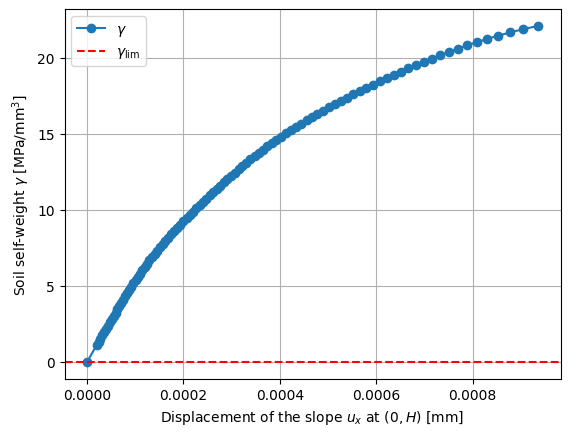

: 

In [ ]:
if len(points_on_process) > 0:
    l_lim = 6.69
    gamma_lim = l_lim / H * c
    plt.plot(results[:, 0], results[:, 1], "o-", label=r"$\gamma$")
    plt.axhline(y=gamma_lim, color="r", linestyle="--", label=r"$\gamma_\text{lim}$")
    plt.xlabel(r"Displacement of the slope $u_x$ at $(0, H)$ [mm]")
    plt.ylabel(r"Soil self-weight $\gamma$ [MPa/mm$^3$]")
    plt.grid()
    plt.legend()

In [33]:
external_operator_problem.performance_monitor

,Newton_iterations,matrix_assembling,vector_assembling,nonlinear_solver,constitutive_model_update
0,1,0.04,0.00,1.03,0.48
1,3,0.10,0.01,3.51,1.76
2,2,0.07,0.00,2.32,1.20
3,2,0.11,0.01,3.10,1.51
4,2,0.06,0.01,2.33,1.23
...,...,...,...,...,...
94,4,0.12,0.01,4.93,2.49
95,4,0.15,0.02,4.73,2.49
96,4,0.12,0.02,4.70,2.41
97,4,0.13,0.02,4.72,2.45


In [34]:
import pickle
with open("performance_monitor_100_100", "wb") as f:
        pickle.dump(external_operator_problem.performance_monitor, f)

In [4]:
# pickle_file = Path("performance_monitor_200_200") 
with open("performance_monitor_200_200", 'rb') as f:
    performance_monitor_200_200 = pickle.load(f)

<Axes: >

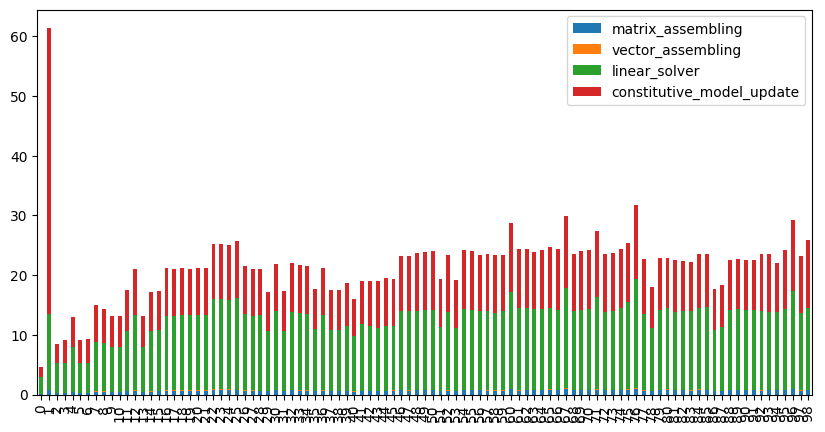

In [5]:
summary_monitor = performance_monitor_200_200.copy()

cols = ["matrix_assembling", "vector_assembling", "linear_solver", "constitutive_model_update"]
summary_monitor["linear_solver"] = summary_monitor["nonlinear_solver"] - summary_monitor["matrix_assembling"] - summary_monitor["vector_assembling"] - summary_monitor["constitutive_model_update"]

fig, ax = plt.subplots(figsize=(10, 5))
summary_monitor.plot(use_index=True, y=cols, kind="bar", stacked=True, ax=ax)

<Axes: >

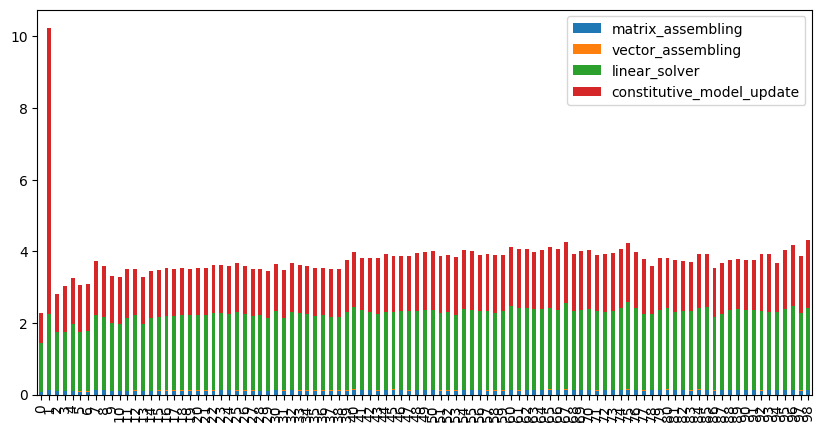

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
for col in cols:
    summary_monitor[col] = summary_monitor[col] / (summary_monitor["Newton_iterations"]+1)
summary_monitor.plot(use_index=True, y=cols, kind="bar", stacked=True, ax=ax)

The slope profile reaching its stability limit:

In [ ]:
try:
    import pyvista

    print(pyvista.global_theme.jupyter_backend)
    import dolfinx.plot

    pyvista.start_xvfb(0.1)

    W = fem.functionspace(domain, ("Lagrange", 1, (gdim,)))
    u_tmp = fem.Function(W, name="Displacement")
    u_tmp.interpolate(u)

    pyvista.start_xvfb()
    plotter = pyvista.Plotter(window_size=[600, 400])
    topology, cell_types, x = dolfinx.plot.vtk_mesh(domain)
    grid = pyvista.UnstructuredGrid(topology, cell_types, x)
    vals = np.zeros((x.shape[0], 3))
    vals[:, : len(u_tmp)] = u_tmp.x.array.reshape((x.shape[0], len(u_tmp)))
    grid["u"] = vals
    warped = grid.warp_by_vector("u", factor=20)
    plotter.add_text("Displacement field", font_size=11)
    plotter.add_mesh(warped, show_edges=False, show_scalar_bar=True)
    plotter.view_xy()
    plotter.show()
except ImportError:
    print("pyvista required for this plot")

### Yield surface

We verify that the constitutive model is correctly implemented by tracing the
yield surface. We generate several stress paths and check whether they remain
within the Mohr-Coulomb yield surface. The stress tracing is performed in the
[Haigh-Westergaard coordinates](https://en.wikipedia.org/wiki/Lode_coordinates)
$(\xi, \rho, \theta)$ which are defined as follows

$$
    \xi = \frac{1}{\sqrt{3}}I_1, \quad \rho =
    \sqrt{2J_2}, \quad \sin(3\theta) = -\frac{3\sqrt{3}}{2}
    \frac{J_3}{J_2^{3/2}},
$$
where $J_3(\boldsymbol{\sigma}) = \det(\boldsymbol{s})$ is the third invariant
of the deviatoric part of the stress tensor, $\xi$ is the deviatoric coordinate,
$\rho$ is the radial coordinate and the angle $\theta \in
[-\frac{\pi}{6}, \frac{\pi}{6}]$ is called Lode or stress angle.

To generate the stress paths we use the principal
stresses formula written in Haigh-Westergaard coordinates as follows

$$
    \begin{pmatrix}
        \sigma_{I} \\
        \sigma_{II} \\
        \sigma_{III}
    \end{pmatrix}
    = p
    \begin{pmatrix}
        1 \\
        1 \\
        1
    \end{pmatrix}
    + \frac{\rho}{\sqrt{2}}
    \begin{pmatrix}
        \cos\theta + \frac{\sin\theta}{\sqrt{3}} \\
        -\frac{2\sin\theta}{\sqrt{3}} \\
        \frac{\sin\theta}{\sqrt{3}} - \cos\theta
    \end{pmatrix},
$$

where $p = \xi/\sqrt{3}$ is a hydrostatic variable and $\sigma_{I} \geq
\sigma_{II} \geq \sigma_{III}$.

Now we generate the loading path by evaluating principal stresses in
Haigh-Westergaard coordinates for the Lode angle $\theta$ being varied from
$-\frac{\pi}{6}$ to $\frac{\pi}{6}$ with fixed $\rho$ and $p$.

In [ ]:
N_angles = 50
N_loads = 9  # number of loadings or paths
eps = 0.00001
R = 0.7  # fix the values of rho
p = 0.1  # fix the deviatoric coordinate
theta_1 = -np.pi / 6
theta_2 = np.pi / 6

theta_values = np.linspace(theta_1 + eps, theta_2 - eps, N_angles)
theta_returned = np.empty((N_loads, N_angles))
rho_returned = np.empty((N_loads, N_angles))
sigma_returned = np.empty((N_loads, N_angles, stress_dim))

# fix an increment of the stress path
dsigma_path = np.zeros((N_angles, stress_dim))
dsigma_path[:, 0] = (R / np.sqrt(2)) * (np.cos(theta_values) + np.sin(theta_values) / np.sqrt(3))
dsigma_path[:, 1] = (R / np.sqrt(2)) * (-2 * np.sin(theta_values) / np.sqrt(3))
dsigma_path[:, 2] = (R / np.sqrt(2)) * (np.sin(theta_values) / np.sqrt(3) - np.cos(theta_values))

sigma_n_local = np.zeros_like(dsigma_path)
sigma_n_local[:, 0] = p
sigma_n_local[:, 1] = p
sigma_n_local[:, 2] = p
derviatoric_axis = tr

Then, we define and vectorize functions `rho`, `Lode_angle` and `sigma_tracing`
evaluating respectively the coordinates $\rho$, $\theta$ and the corrected (or
"returned") stress tensor for a certain stress state. `sigma_tracing` calls the
function `return_mapping`, where the constitutive model was defined via JAX
previously.

In [ ]:
def rho(sigma_local):
    s = dev @ sigma_local
    return jnp.sqrt(2.0 * J2(s))


def Lode_angle(sigma_local):
    s = dev @ sigma_local
    arg = -(3.0 * jnp.sqrt(3.0) * J3(s)) / (2.0 * jnp.sqrt(J2(s) * J2(s) * J2(s)))
    arg = jnp.clip(arg, -1.0, 1.0)
    angle = 1.0 / 3.0 * jnp.arcsin(arg)
    return angle


def sigma_tracing(sigma_local, sigma_n_local):
    deps_elas = S_elas @ sigma_local
    sigma_corrected, state = return_mapping(deps_elas, sigma_n_local)
    yielding = state[2]
    return sigma_corrected, yielding


Lode_angle_v = jax.jit(jax.vmap(Lode_angle, in_axes=(0)))
rho_v = jax.jit(jax.vmap(rho, in_axes=(0)))
sigma_tracing_v = jax.jit(jax.vmap(sigma_tracing, in_axes=(0, 0)))

For each stress path, we call the function `sigma_tracing_v` to get the
corrected stress state and then we project it onto the deviatoric plane $(\rho,
\theta)$ with a fixed value of $p$.

In [ ]:
for i in range(N_loads):
    print(f"Loading path#{i}")
    dsigma, yielding = sigma_tracing_v(dsigma_path, sigma_n_local)
    dp = dsigma @ tr / 3.0 - p
    dsigma -= np.outer(dp, derviatoric_axis)  # projection on the same deviatoric plane

    sigma_returned[i, :] = dsigma
    theta_returned[i, :] = Lode_angle_v(dsigma)
    rho_returned[i, :] = rho_v(dsigma)
    print(f"max f: {jnp.max(yielding)}\n")
    sigma_n_local[:] = dsigma

Then, by knowing the expression of the [standrad
Mohr-Coulomb](https://en.wikipedia.org/wiki/Mohr%E2%80%93Coulomb_theory) yield
surface in principle stresses, we can obtain an analogue expression in
Haigh-Westergaard coordinates, which leads us to the following equation:


$$
    \frac{\rho}{\sqrt{6}}(\sqrt{3}\cos\theta + \sin\phi
    \sin\theta) - p\sin\phi - c\cos\phi= 0.
$$ (eq:standard_MC)

Thus, we restore the standard Mohr-Coulomb yield surface:

In [ ]:
def MC_yield_surface(theta_, p):
    """Restores the coordinate `rho` satisfying the standard Mohr-Coulomb yield
    criterion."""
    rho = (np.sqrt(2) * (c * np.cos(phi) + p * np.sin(phi))) / (
        np.cos(theta_) - np.sin(phi) * np.sin(theta_) / np.sqrt(3)
    )
    return rho


rho_standard_MC = MC_yield_surface(theta_values, p)

Finally, we plot the yield surface:

In [ ]:
colormap = cm.plasma
colors = colormap(np.linspace(0.0, 1.0, N_loads))

fig, ax = plt.subplots(subplot_kw={"projection": "polar"}, figsize=(8, 8))
# Mohr-Coulomb yield surface with apex smoothing
for i, color in enumerate(colors):
    rho_total = np.array([])
    theta_total = np.array([])
    for j in range(12):
        angles = j * np.pi / 3 - j % 2 * theta_returned[i] + (1 - j % 2) * theta_returned[i]
        theta_total = np.concatenate([theta_total, angles])
        rho_total = np.concatenate([rho_total, rho_returned[i]])

    ax.plot(theta_total, rho_total, ".", color=color)

# standard Mohr-Coulomb yield surface
theta_standard_MC_total = np.array([])
rho_standard_MC_total = np.array([])
for j in range(12):
    angles = j * np.pi / 3 - j % 2 * theta_values + (1 - j % 2) * theta_values
    theta_standard_MC_total = np.concatenate([theta_standard_MC_total, angles])
    rho_standard_MC_total = np.concatenate([rho_standard_MC_total, rho_standard_MC])
ax.plot(theta_standard_MC_total, rho_standard_MC_total, "-", color="black")
ax.set_yticklabels([])

norm = mcolors.Normalize(vmin=0.1, vmax=0.7 * 9)
sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation="vertical")
cbar.set_label(r"Magnitude of the stress path deviator, $\rho$ [MPa]")

plt.show()

Each colour represents one loading path. The circles are associated with the
loading during the elastic phase. Once the loading reaches the elastic limit,
the circles start outlining the yield surface, which in the limit lay along the
standard Mohr-Coulomb one without smoothing (black contour).

### Taylor test

Here, we perform a Taylor test to check that the form $F$ and its Jacobian $J$
are consistent zeroth- and first-order approximations of the residual $F$. In
particular, the test verifies that the program `dsigma_ddeps_vec`
obtained by the JAX's AD returns correct values of the external operator
$\boldsymbol{\sigma}$ and its derivative $\boldsymbol{C}_\text{tang}$, which
define $F$ and $J$ respectively.

To perform the test, we introduce the
operators $\mathcal{F}: V \rightarrow V^\prime$ and $\mathcal{J}: V \rightarrow \mathcal{L}(V,
V^\prime)$ defined as follows:

$$
    \langle \mathcal{F}(\boldsymbol{u}), \boldsymbol{v} \rangle :=
    F(\boldsymbol{u}; \boldsymbol{v}), \quad \forall \boldsymbol{v} \in V,
$$
$$
    \langle (\mathcal{J}(\boldsymbol{u}))(k\boldsymbol{\delta u}),
    \boldsymbol{v} \rangle := J(\boldsymbol{u}; k\boldsymbol{\delta u},
    \boldsymbol{v}), \quad \forall \boldsymbol{v} \in V,
$$

where $V^\prime$ is a dual space of $V$, $\langle \cdot, \cdot \rangle$ is the
$V^\prime \times V$ duality pairing and $\mathcal{L}(V, V^\prime)$ is a space of
bounded linear operators from $V$ to its dual.

Then, by following the Taylor's theorem on Banach spaces and perturbating the
functional $\mathcal{F}$ in the direction $k \, \boldsymbol{δu} \in V$ for $k >
0$, the zeroth and first order Taylor reminders $r_k^0$ and $r_k^1$ have the
following *mesh-independent* convergence rates in the dual space $V^\prime$:

$$
    \| r_k^0 \|_{V^\prime} := \| \mathcal{F}(\boldsymbol{u} + k \,
    \boldsymbol{\delta u}) - \mathcal{F}(\boldsymbol{u}) \|_{V^\prime}
    \longrightarrow 0 \text{ at } O(k),
$$ (eq:r0)
$$
    \| r_k^1 \|_{V^\prime} := \| \mathcal{F}(\boldsymbol{u} + k \,
    \boldsymbol{\delta u}) - \mathcal{F}(\boldsymbol{u}) - \,
    (\mathcal{J}(\boldsymbol{u}))(k\boldsymbol{\delta u}) \|_{V^\prime}
    \longrightarrow 0 \text{ at } O(k^2).
$$ (eq:r1)

In order to compute the norm of an element $f \in V^\prime$ from the dual space
$V^\prime$, we apply the Riesz representation theorem, which states that there
is a linear isometric isomorphism $\mathcal{R} : V^\prime \to V$, which
associates a linear functional $f$ with a unique element $\mathcal{R} f =
\boldsymbol{u} \in V$. In practice, within a finite subspace $V_h \subset V$, the
Riesz map $\mathcal{R}$ is represented by the matrix $\mathsf{L}^{-1}$, the
inverse of the Laplacian operator {cite}`kirbyFunctional2010`

$$
    \mathsf{L}_{ij} = \int\limits_\Omega \nabla\varphi_i \cdot \nabla\varphi_j \mathrm{d} x , \quad i,j = 1, \dots, n,
$$

where $\{\varphi_i\}_{i=1}^{\dim V_h}$ is a set of basis function of the space
$V_h$.

If the Euclidean vectors $\mathsf{r}_k^i \in \mathbb{R}^{\dim V_h}, \, i \in
\{0,1\}$ represent the Taylor remainders from {eq}`eq:r0`--{eq}`eq:r1` in the
finite space, then the dual norms are computed through the following formula
{cite}`kirbyFunctional2010`

$$
    \| r_k^i \|^2_{V^\prime_h} = (\mathsf{r}_k^i)^T \mathsf{L}^{-1} \mathsf{r}_k^i, \quad i \in \{0,1\}.
$$ (eq:r_norms)

In practice, the vectors $\mathsf{r}_k^i$ are defined through the residual
vector $\mathsf{F} \in \mathbb{R}^{\dim V_h}$ and the Jacobian matrix
$\mathsf{J} \in \mathbb{R}^{\dim V_h\times\dim V_h}$

$$
    \mathsf{r}_k^0 = \mathsf{F}(\mathsf{u} + k \, \mathsf{\delta u}) - \mathsf{F}(\mathsf{u}) \in \mathbb{R}^n,
$$ (eq:vec_r0)
$$
    \mathsf{r}_k^1 = \mathsf{F}(\mathsf{u} + k \, \mathsf{\delta u}) -
    \mathsf{F}(\mathsf{u}) - \, \mathsf{J}(\mathsf{u}) \cdot k\mathsf{\delta
    u} \in \mathbb{R}^n,
$$ (eq:vec_r1)

where $\mathsf{u} \in \mathbb{R}^{\dim V_h}$ and $\mathsf{\delta u} \in
\mathbb{R}^{\dim V_h}$ represent dispacement fields $\boldsymbol{u} \in V_h$ and
$\boldsymbol{\delta u} \in V_h$.

Now we can proceed with the Taylor test implementation. Let us first start with
defining the Laplace operator.

In [ ]:
L_form = fem.form(ufl.inner(ufl.grad(u_hat), ufl.grad(v)) * ufl.dx)
L = fem.petsc.assemble_matrix(L_form, bcs=bcs)
L.assemble()
Riesz_solver = PETSc.KSP().create(domain.comm)
Riesz_solver.setType("preonly")
Riesz_solver.getPC().setType("lu")
Riesz_solver.setOperators(L)
y = fem.Function(V, name="Riesz_representer_of_r")  # r - a Taylor remainder

Now we initialize main variables of the plasticity problem.

In [ ]:
# Reset main variables to zero including the external operators values
sigma_n.x.array[:] = 0.0
sigma.ref_coefficient.x.array[:] = 0.0
J_external_operators[0].ref_coefficient.x.array[:] = 0.0
# Reset the values of the consistent tangent matrix to elastic moduli
Du.x.array[:] = 1.0
evaluated_operands = evaluate_operands(F_external_operators)
_ = evaluate_external_operators(J_external_operators, evaluated_operands)

As the derivatives of the constitutive model are different for elastic and
plastic phases, we must consider two initial states for the Taylor test. For
this reason, we solve the problem once for a certain loading value to get the
initial state close to the one with plastic deformations but still remain in the
elastic phase.

In [ ]:
i = 0
load = 2.0
q.value = load * np.array([0, -gamma])
external_operator_problem.assemble_vector()

residual_0 = external_operator_problem.b.norm()
residual = residual_0
Du.x.array[:] = 0

if MPI.COMM_WORLD.rank == 0:
    print(f"Load increment #{i}, load: {load}, initial residual: {residual_0}")

for iteration in range(0, max_iterations):
    if residual / residual_0 < relative_tolerance:
        break

    if MPI.COMM_WORLD.rank == 0:
        print(f"\tOuter Newton iteration #{iteration}")
    external_operator_problem.assemble_matrix()
    external_operator_problem.solve(du)

    Du.x.petsc_vec.axpy(1.0, du.x.petsc_vec)
    Du.x.scatter_forward()

    evaluated_operands = evaluate_operands(F_external_operators)
    ((_, sigma_new),) = evaluate_external_operators(J_external_operators, evaluated_operands)

    sigma.ref_coefficient.x.array[:] = sigma_new

    external_operator_problem.assemble_vector()
    residual = external_operator_problem.b.norm()

    if MPI.COMM_WORLD.rank == 0:
        print(f"\tResidual: {residual}\n")

sigma_n.x.array[:] = sigma.ref_coefficient.x.array

# Initial values of the displacement field and the stress state for the Taylor
# test
Du0 = np.copy(Du.x.array)
sigma_n0 = np.copy(sigma_n.x.array)

If we take into account the initial stress state `sigma_n0` computed in the cell
above, we perform the Taylor test for the plastic phase, otherwise we stay in
the elastic one.

Finally, we define the function `perform_Taylor_test`, which returns the norms
of the Taylor reminders in dual space {eq}`eq:r_norms`--{eq}`eq:vec_r1`.

In [ ]:
k_list = np.logspace(-2.0, -6.0, 5)[::-1]


def perform_Taylor_test(Du0, sigma_n0):
    # r0 = F(Du0 + k*δu) - F(Du0)
    # r1 = F(Du0 + k*δu) - F(Du0) - k*J(Du0)*δu
    Du.x.array[:] = Du0
    sigma_n.x.array[:] = sigma_n0
    evaluated_operands = evaluate_operands(F_external_operators)
    ((_, sigma_new),) = evaluate_external_operators(J_external_operators, evaluated_operands)
    sigma.ref_coefficient.x.array[:] = sigma_new

    F0 = fem.petsc.assemble_vector(F_form)  # F(Du0)
    F0.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.set_bc(F0, bcs)

    J0 = fem.petsc.assemble_matrix(J_form, bcs=bcs)
    J0.assemble()  # J(Du0)
    Ju = J0.createVecLeft()  # Ju = J0 @ u

    δu = fem.Function(V)
    δu.x.array[:] = Du0  # δu == Du0

    zero_order_remainder = np.zeros_like(k_list)
    first_order_remainder = np.zeros_like(k_list)

    for i, k in enumerate(k_list):
        Du.x.array[:] = Du0 + k * δu.x.array
        evaluated_operands = evaluate_operands(F_external_operators)
        ((_, sigma_new),) = evaluate_external_operators(J_external_operators, evaluated_operands)
        sigma.ref_coefficient.x.array[:] = sigma_new

        F_delta = fem.petsc.assemble_vector(F_form)  # F(Du0 + h*δu)
        F_delta.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem.set_bc(F_delta, bcs)

        J0.mult(δu.x.petsc_vec, Ju)  # Ju = J(Du0)*δu
        Ju.scale(k)  # Ju = k*Ju

        r0 = F_delta - F0
        r1 = F_delta - F0 - Ju

        Riesz_solver.solve(r0, y.x.petsc_vec)  # y = L^{-1} r0
        y.x.scatter_forward()
        zero_order_remainder[i] = np.sqrt(r0.dot(y.x.petsc_vec))  # sqrt{r0^T L^{-1} r0}

        Riesz_solver.solve(r1, y.x.petsc_vec)  # y = L^{-1} r1
        y.x.scatter_forward()
        first_order_remainder[i] = np.sqrt(r1.dot(y.x.petsc_vec))  # sqrt{r1^T L^{-1} r1}

    return zero_order_remainder, first_order_remainder


print("Elastic phase")
zero_order_remainder_elastic, first_order_remainder_elastic = perform_Taylor_test(Du0, 0.0)
print("Plastic phase")
zero_order_remainder_plastic, first_order_remainder_plastic = perform_Taylor_test(Du0, sigma_n0)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].loglog(k_list, zero_order_remainder_elastic, "o-", label=r"$\|r_k^0\|_{V^\prime}$")
axs[0].loglog(k_list, first_order_remainder_elastic, "o-", label=r"$\|r_k^1\|_{V^\prime}$")
annotation.slope_marker((2e-4, 5e-5), 1, ax=axs[0], poly_kwargs={"facecolor": "tab:blue"})
axs[0].text(0.5, -0.2, "(a) Elastic phase", transform=axs[0].transAxes, ha="center", va="top")

axs[1].loglog(k_list, zero_order_remainder_plastic, "o-", label=r"$\|r_k^0\|_{V^\prime}$")
annotation.slope_marker((2e-4, 5e-5), 1, ax=axs[1], poly_kwargs={"facecolor": "tab:blue"})
axs[1].loglog(k_list, first_order_remainder_plastic, "o-", label=r"$\|r_k^1\|_{V^\prime}$")
annotation.slope_marker((2e-4, 5e-13), 2, ax=axs[1], poly_kwargs={"facecolor": "tab:orange"})
axs[1].text(0.5, -0.2, "(b) Plastic phase", transform=axs[1].transAxes, ha="center", va="top")

for i in range(2):
    axs[i].set_xlabel("k")
    axs[i].set_ylabel("Taylor remainder norm")
    axs[i].legend()
    axs[i].grid()

plt.tight_layout()
plt.show()

first_order_rate = np.polyfit(np.log(k_list), np.log(zero_order_remainder_elastic), 1)[0]
second_order_rate = np.polyfit(np.log(k_list), np.log(first_order_remainder_elastic), 1)[0]
print(f"Elastic phase:\n\tthe 1st order rate = {first_order_rate:.2f}\n\tthe 2nd order rate = {second_order_rate:.2f}")
first_order_rate = np.polyfit(np.log(k_list), np.log(zero_order_remainder_plastic), 1)[0]
second_order_rate = np.polyfit(np.log(k_list[1:]), np.log(first_order_remainder_plastic[1:]), 1)[0]
print(f"Plastic phase:\n\tthe 1st order rate = {first_order_rate:.2f}\n\tthe 2nd order rate = {second_order_rate:.2f}")

For the elastic phase (a) the zeroth-order Taylor remainder $r_k^0$ achieves the
first-order convergence rate, whereas the first-order remainder $r_k^1$ is
computed at the level of machine precision due to the constant Jacobian.
Similarly to the elastic flow, the zeroth-order Taylor remainder $r_k^0$ of the
plastic phase (b) reaches the first-order convergence, whereas the first-order
remainder $r_k^1$ achieves the second-order convergence rate, as expected.

## Performance

In [ ]:
summary_monitor = external_operator_problem.performance_monitor.copy()

cols = ["matrix_assembling", "vector_assembling", "linear_solver", "constitutive_model_update"]
summary_monitor["linear_solver"] = summary_monitor["nonlinear_solver"] - summary_monitor["matrix_assembling"] - summary_monitor["vector_assembling"] - summary_monitor["constitutive_model_update"]

fig, ax = plt.subplots(figsize=(10, 5))
summary_monitor.plot(use_index=True, y=cols, kind="bar", stacked=True, ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
for col in cols:
    summary_monitor[col] = summary_monitor[col] / (summary_monitor["Newton_iterations"]+1)
summary_monitor.plot(use_index=True, y=cols, kind="bar", stacked=True, ax=ax)

In [ ]:
summary_monitor = pd.DataFrame({
    "loading_step": np.array([], dtype=np.int64),
    "matrix_assembling": np.array([], dtype=np.float64),
    "vector_assembling": np.array([], dtype=np.float64),
    "linear_solver": np.array([], dtype=np.float64),
    "constitutive_model_update": np.array([], dtype=np.float64),
})
cols = ["matrix_assembling", "vector_assembling", "linear_solver", "constitutive_model_update"]

In [ ]:
tmp_monitor = {}
for i in range(num_increments):
    tmp_monitor["loading_step"] = i
    for col in cols:
        Newton_iters = performance_monitor[performance_monitor["loading_step"]==i]["Newton_iteration"].iloc[-1] + 1
        tmp_monitor[col] = performance_monitor[performance_monitor["loading_step"]==i][col].sum()/Newton_iters
    summary_monitor.loc[len(summary_monitor.index)] = tmp_monitor

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
summary_monitor.plot(x="loading_step", y=cols, kind="bar", stacked=True, ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
summary_monitor.plot(x="loading_step", y=cols, kind="bar", stacked=True, ax=ax)
# 106.37

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
summary_monitor.plot(x="loading_step", y=cols, kind="bar", stacked=True, ax=ax)
#Total time: 48.410000000000004

In [ ]:
summary_monitor.plot(x="loading_step", y=cols, kind="bar", stacked=True)

## References
```{bibliography}
:filter: docname in docnames
```